# Run py12box model
Run the AGAGE 12-box model

In [1]:
import os
import matplotlib.pyplot as plt
import setup
import core
from ipywidgets import widgets
from IPython.display import display
from pandas import read_csv
from pathlib import Path

In [4]:
input_dir = Path(".") / "inputs"

species_info = read_csv(input_dir / "species_info.csv",
                        index_col = "Species")
#species_list = species_info.index.values
project_paths = [Path('../py12box_projects'), Path("./example")]

In [5]:
project_directories_str = "\n".join([str(pth.resolve()) for pth in project_paths])
proj_textarea = widgets.Textarea(value = project_directories_str,
                                description = "Project_directories")
display(proj_textarea)

Textarea(value='/Users/chxmr/Work/Projects/py12box_projects\n/Users/chxmr/Work/Projects/py12box/example', desc…

In [22]:
project_directories = []
for proj in project_paths:
    for f in proj.glob("*"):
        if (f.is_dir()) and (str(f.name)[0] != "."):
            project_directories.append(f)

project_dropdown = widgets.Dropdown(options = sorted(project_directories),
                                description = "Select project")

case_dropdown = widgets.Dropdown(options = [None],
                                 description = "Select case")

species_dropdown = widgets.Dropdown(options = [None],
                                    description = "Select species")

def update_case_dropdown(*args):
    project_directory = project_dropdown.value
    cases = sorted([p.name for p in project_directory.glob("*/")])
    case_dropdown.options = cases

project_dropdown.observe(update_case_dropdown)
update_case_dropdown()

def update_species_dropdown(*args):
    case = case_dropdown.value
    fnames = [f.name for f in (project_dropdown.value / case).rglob("*.csv")]
    if fnames:
        species_set = set([f.split("_")[0] for f in fnames])
        species_dropdown.options = species_set
    else:
        species_dropdown.options = ["ERROR: no files found"]

case_dropdown.observe(update_species_dropdown)
update_species_dropdown()

display(project_dropdown)
display(case_dropdown)
display(species_dropdown)


Dropdown(description='Select project', options=(PosixPath('../py12box_projects/AGAGE'), PosixPath('../py12box_…

Dropdown(description='Select case', options=('CFC-11',), value='CFC-11')

Dropdown(description='Select species', options=('CFC-11',), value='CFC-11')

In [27]:
project_directory = project_dropdown.value
case = case_dropdown.value
species = species_dropdown.value
mol_mass = species_info["Molecular mass (g/mol)"][species]

time, emissions, ic, lifetime = setup.get_species_parameters(project_directory,
                                                             case,
                                                             species)

i_t, i_v1, t, v1, OH, Cl, temperature = setup.get_model_parameters(input_dir,
                                                                   int(len(time) / 12))
F = setup.transport_matrix(i_t, i_v1, t, v1)
c_month, burden, emissions_out, losses, lifetimes = \
    core.model(ic=ic, q=emissions,
               mol_mass=mol_mass,
               lifetime=lifetime,
               F=F,
               temp=temperature,
               Cl=Cl, OH=OH)

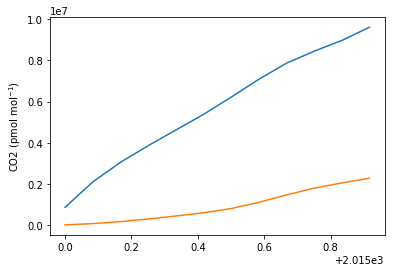

In [28]:
plt.plot(time, c_month[:, 0])
plt.plot(time, c_month[:, 3])
plt.ylabel("%s (pmol mol$^{-1}$)" % species)
plt.show()